In [1]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive connected.")
%cd ./drive/MyDrive/colab/tumor_classification/

Mounted at /content/drive
Google Drive connected.
/content/drive/MyDrive/colab/tumor_classification


In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
!mkdir data
!unzip brain-tumor-classification-mri -d data

In [2]:
!ls data

Testing  Training


In [5]:
import torch
import torchvision
from torchvision import datasets, models, transforms

preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop((256,256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.ColorJitter(),
                transforms.RandomHorizontalFlip(),
            ])
trainset=torchvision.datasets.ImageFolder(root='data/Training/', transform=preprocess)
testset=torchvision.datasets.ImageFolder(root='data/Testing/', transform=preprocess)

trainloader=torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader=torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

dataset_sizes = len(trainset)

class_names = trainset.classes
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


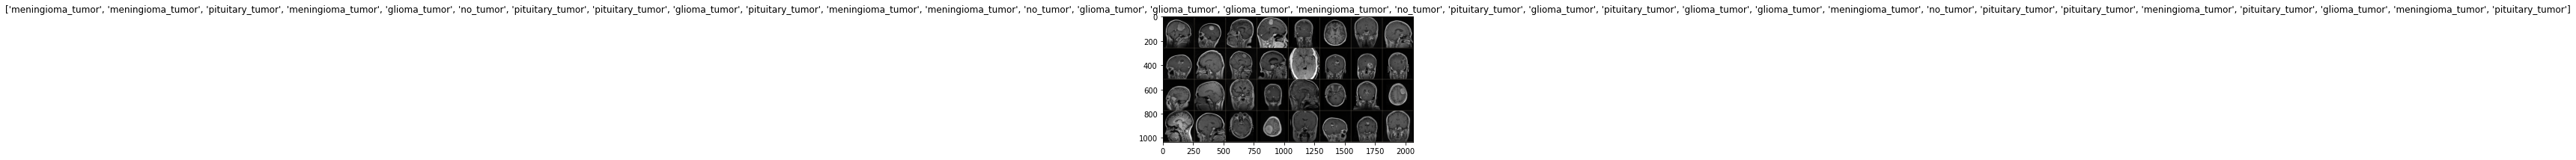

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
import torch.nn as nn
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [9]:
import time
import os
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(trainloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

num_classes = 4

# For Inception V3
"""
model_ft = models.inception_v3(pretrained=True)

aux_features = model_ft.AuxLogits.fc.in_features
fc_features = model_ft.fc.in_features

model_ft.AuxLogits.fc = nn.Linear(aux_features, num_classes)
model_ft.fc = nn.Linear(fc_features, num_classes)
"""

# For Resnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = torch.load('tumor_classification_model.pt')
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print(model_ft)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6323 Acc: 0.7516
val Loss: 0.2790 Acc: 0.9091

Epoch 1/49
----------
train Loss: 0.2539 Acc: 0.9122
val Loss: 0.1409 Acc: 0.9592

Epoch 2/49
----------
train Loss: 0.1535 Acc: 0.9449
val Loss: 0.1016 Acc: 0.9683

Epoch 3/49
----------
train Loss: 0.0995 Acc: 0.9690
val Loss: 0.0455 Acc: 0.9916

Epoch 4/49
----------
train Loss: 0.0662 Acc: 0.9836
val Loss: 0.0254 Acc: 0.9972

Epoch 5/49
----------
train Loss: 0.0438 Acc: 0.9895
val Loss: 0.0225 Acc: 0.9983

Epoch 6/49
----------
train Loss: 0.0349 Acc: 0.9927
val Loss: 0.0180 Acc: 0.9986

Epoch 7/49
----------
train Loss: 0.0254 Acc: 0.9955
val Loss: 0.0101 Acc: 0.9997

Epoch 8/49
----------
train Loss: 0.0223 Acc: 0.9972
val Loss: 0.0091 Acc: 0.9993

Epoch 9/49
----------
train Loss: 0.0191 Acc: 0.9986
val Loss: 0.0082 Acc: 0.9997

Epoch 10/49
----------
train Loss: 0.0212 Acc: 0.9976
val Loss: 0.0081 Acc: 0.9997

Epoch 11/49
----------
train Loss: 0.0191 Acc: 0.9979
val Loss: 0.0080 Acc: 1.0000

Ep

In [17]:
def test_model(model,loader):
  correct = 0
  total = 0

  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      # calculate outputs by running images through the network
      outputs = model(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    
  print("Accuracy: ", round(correct/total, 3))
  
test_model(model_ft,testloader)

Accuracy:  0.761


In [18]:
torch.save(model_ft,'tumor_classification_model.pt')